<a href="https://www.kaggle.com/code/flakkyddon/customer-clustering?scriptVersionId=289257520" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CUSTOMER SEGMENTATION:USING KMEANS CLUSTERING 🛒🛒🛒

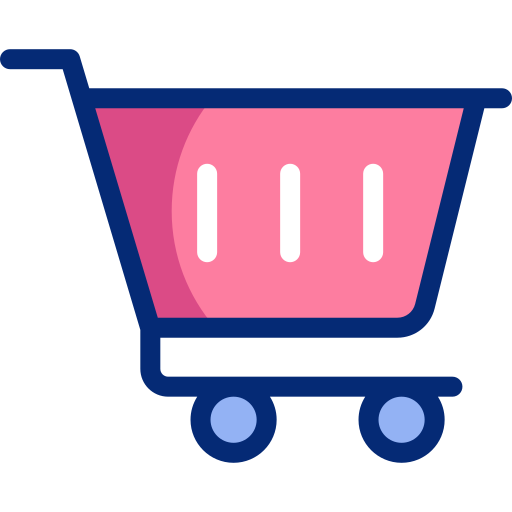

### **Project Overview: Segmentation for a Supermarket Chain**
The goal of the project is to clean, explore, preprocess, and cluster supermarket customers using demographic, behavioural, and marketing interaction data. The final deliverable will include a reusable clustering model capable of assigning **new customers** to the most appropriate segment.

# 1.0 **THE DATASET**
The dataset contains a rich blend of demographic attributes, purchasing behaviour, marketing engagement, and campaign response indicators. For clarity, the variables can be grouped into five logical categories:

---
## **1.1 Customer information**
These features describe the customer’s demographic profile and basic engagement history.

| Variable | Description |
|---------|-------------|
| **ID** | Unique customer identifier |
| **Year_Birth** | Year of birth (used to derive age) |
| **Education** | Highest education level attained |
| **Marital_Status** | Current marital status |
| **Income** | Annual household income |
| **Kidhome** | Number of children in the household |
| **Teenhome** | Number of teenagers in the household |
| **Dt_Customer** | Date the customer enrolled with the company |
| **Recency** | Days since last purchase |
| **Complain** | Whether the customer has lodged a complaint |

---
## **1.2 Product Spending / Customer Lifetime Value Components**
These variables capture the total amount spent by each customer across product categories. Summing these variables provides a proxy for **Customer lifetime Value(CLV)** within the dataset's timeframe.

| Variable | Description |
|---------|-------------|
| **MntWines** | Amount spent on wine |
| **MntFruits** | Amount spent on fruits |
| **MntMeatProducts** | Amount spent on meat products |
| **MntFishProducts** | Amount spent on fish products |
| **MntSweetProducts** | Amount spent on sweets |
| **MntGoldProds** | Amount spent on gold products |

---
## **1.3 Channel Contribution**
These features describe how customers interact with different purchasing channels.

| Variable | Description |
|---------|-------------|
| **NumWebPurchases** | Number of purchases made through the website |
| **NumCatalogPurchases** | Number of purchases made via catalogue |
| **NumStorePurchases** | Number of purchases made in-store |
| **NumWebVisitsMonth** | Number of website visits in the last month |

---
## **1.4 Promotions & Campaign Response**
These variables capture how customers respond to promotional campaigns and deals 

| Variable | Description |
|---------|-------------|
| **NumDealsPurchases** | Purchases made using a discount or deal |
| **AcceptedCmp1–AcceptedCmp5** | Whether the customer accepted each of the five past campaigns |
| **Response** | Acceptance of the most recent campaign |

---
## **1.5 Customer Acquisition Cost**
These variables capture information about the cost of the customer to this business.

| Variable | Description |
|---------|-------------|
| **Z_CostContact** | Cost of contacting the customer (constant in this dataset) |

In [ ]:
# Import libraries for the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer # type: ignore
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
# Import the Dataset
df = pd.read_csv("../input/customer-personality-analysis/marketing_campaign.csv", sep="\t")
df.head(5)

In [ ]:
# Get a feel for the dataset by .info(), .describe() for all features
df.info()
df.describe(include = [np.number]) #summarize all non null values, it excludes categorical columns
df.describe(include = 'object') #summarize all non null values, it includes categorical columns

In [ ]:
df.isnull().sum()

## **1.6 📌Key Data Quality Observations**

1. **Missing Values in Income**
The income feature has 2216 non-null values, meaning 24 missing entries. This is a critical variable for segmentation, so we must decide whether to:

    * Impute (median is usually safest for skewed income distributions), or
    * Drop those rows if they are few and not systematically biased.
   
---
2. **Misaligned Data-type in Dt_Customer**
This must be converted to a datetime type later, 

    * we will engineer using pd.to_datime to compute a new value 'Customer tenure'
    * Possibly recency buckets or loyalty indicators
  
 ___   
3.  **Wrongly labelled Categorical Variables Need Cleaning**

Education and Marital_Status are known to often contain inconsistent categories in most datasets.

For examples in this dataset, you will find:

    "2n Cycle", "Basic", "Graduation", "PhD"
    "Married", "Together", "Single", "Divorced", "Widow", "YOLO", "Absurd"

We will need to consolidate these into meaningful, business‑friendly groups
    
 --- 
4. **All Spending and Behavioural Columns Are Numeric**

For this dataset, this is good, therefore no type conversion is needed.

However, we will later:.

    * Check for zero‑inflation (many customers spend nothing in certain categories)
    * Scale these variables before clustering
    
___
5. **No Missing Value in Campaign or Channel Column**
   
This means:

    * Campaign response data is complete
    * Channel usage data is complete
    
Therefore, no imputation is needed here.
___
6.  **"Z_Revenue" and "Z_CostContact"**
These are constant fields in this dataset (always the same value). As mentioned earlier, these will be dropped because they will add no value to the task at hand (Customer Clustering).

---
### **Feature Engineering Consideration**

Create a **Tenure** variable:

```python
df['Tenure'] = (df['Dt_Customer'] - df['Dt_Customer'].min()).dt.days
```

Customer tenure is often a strong driver of customer segmentation.

---

### **📌 What Next? **

- Handle missing income 
- Clean and consolidate categories  
- Engineer new features (age, tenure, total spend)  
- Prepare the dataset for scaling and clustering  

# **2.0 📦DATA CLEANING AND CONSOLIDATION**

To prepare the dataset for meaningful customer segmentation, several variables need to be transformed or consolidated into clearer, more analytically useful forms. These engineered features will help us better understand customer demographics, household structure, and overall value to the business. The following strategies outline the key steps taken during data consolidation:

## 2.1 🧩Handling Missing Values

In [ ]:
# To commence this exercise, we will drop all NA especially from the income variable
dfa = df.dropna()
print("Customer data after deleting null values:", len(dfa))

After removing the 24 records with missing income values, the cleaned dataset contains 2,216 customers.
This represents a minimal reduction in sample size and ensures that all remaining observations have complete financial information for accurate segmentation.

## **2.2 📅Conversion of Dt_Customer from Object to Date-time Data_type**

This is Dt_Customer is stored as an object data-type but needs to be converted to a date field.
The column has 663 unique data, this is expected as date usually have a high number of unique values, as observed. The most frequent date (31/08/2012) which appears 12 times, this is normal.

**Required Cleaning**
Convert it from object data type to date-time data type.

In [ ]:
# Create a copy to ensure we are working with a safe copy of the dataset
#dfa = dfa.copy()

# Parse the DT_Customer to a date column
dfa['Dt_Customer'] = pd.to_datetime(dfa['Dt_Customer'], dayfirst = True)

# Vectorized feature extarction
dfa["Year"] = dfa['Dt_Customer'].dt.year # Extracts year
dfa['Month'] = dfa['Dt_Customer'].dt.month # Extracts month
dfa['Day'] = dfa['Dt_Customer'].dt.day # Extracts day
dfa['Weekday'] = dfa['Dt_Customer'].dt.day_name() # Extracts week day nameis a .dt method
dfa['Quarter'] = dfa['Dt_Customer'].dt.quarter

# Create a new feature Customer Tenure
# This is the done by checking the customer's last record0 

dfa['Tenure'] = (dfa['Dt_Customer'] - dfa['Dt_Customer'].min()).dt.days

# Preview the first 5 records
print(dfa[['Dt_Customer', 'Year', 'Month', 'Day', 'Weekday', 'Tenure']].head())

## **2.3 Calculation of Age From Birth_Year**
The original `Year_Birth` field was converted into a numerical **Age** variable.  
This allows us to group customers into age brackets and identify behavioural patterns across generations. 
To generate a reliable Age variable, we calculated each customer’s age using the most recent year present in the DT_Customer field. This ensures that all ages are aligned to the same reference point and reflect the most up‑to‑date customer information. The Year_Birth field was first converted into a date time format, and age was computed as the difference between the latest customer enrolment year and the customer’s birth year. This approach avoids inconsistencies that would arise from using the earliest enrolment date and ensures accurate demographic profiling for segmentation.

In [ ]:
# Represent customer ages in numerice format using min year from the DT column

# Checks that Year_Birth is in datetime-like (year precision)
if not np.issubdtype(dfa['Year_Birth'].dtype, np.datetime64):
	dfa['Year_Birth'] = pd.to_datetime(dfa['Year_Birth'], format='%Y', errors='coerce')

# Use the minimum year from the already parsed DT_Customer datetime column
min_year = dfa['Dt_Customer'].dt.year.max()
    
# Calculate age (as of min year in DT_Customer)
dfa['Age'] = min_year - dfa['Year_Birth'].dt.year

print(dfa['Age'].head())

## **2.4 Modification of 🎓Education Levels**
The `Education` categories were reclassified to improve readability and reduce noise.  
Some of the original labels were inconsistent or overly granular, so they were consolidated into clearer, business‑friendly groups (e.g., *Basic*, *Graduate*, *Postgraduate*).

In [ ]:
#  Identidy unique features of each Categorical Variables
dfa['Education'].unique()

In [ ]:
dfa['Education'].value_counts()

**— 5 Unique Categories**

The dataset contains **5 education levels**, with **“Graduation”** being the most common (over half of the dataset).

We need to check the raw categories because this dataset is known to include:

- `"2n Cycle"`
- `"Basic"`
- `"Graduation"`
- `"Master"`
- `"PhD"`

This needs to be adjusted to capture business friendly and interpretable words to measure up to required business logic. The following steps will be carried out:

- Rename `"Basic"` as "High School"
- and `"2n Cycle"` as "Undergraduate"
- Change  `"Graduation"`to "Bachelor\'s Degree" for legibility
- Keep `"Master"`, `"PhD"` as "Master\'s Degree" and "Doctorate" 

This reduces noise and improves interpretability of clusters.

In [ ]:
# Rename 'Education' values for better readability

dfa['Education'] = dfa['Education'].replace({
    'Basic':'High School',
    '2n Cycle':'Undergraduate',
    'Graduation':'Bachelor\'s Degree',
    'Master':'Master\'s Degree',
    'PhD':'Doctorate'
})

## **2.5 Redefinition of 💍Marital Statuses**
The `Marital_Status` field contained several ambiguous or non‑standard entries.  
These were cleaned and grouped into broader, more interpretable categories (e.g., *Single*, *Partnered*, *Other*).  
This ensures consistent representation and supports more accurate segmentation.


In [ ]:
dfa['Marital_Status'].unique()

In [ ]:
dfa['Marital_Status'].value_counts()

**- 8 Unique Categories**

This is the column that typically needs the most cleaning.

This dataset contains:

- `"Married"`
- `"Together"`
- `"Single"`
- `"Divorced"`
- `"Widow"`
- `"Alone"`
- `"YOLO"`
- `"Absurd"`

The last two are clearly **data entry anomalies**.

**Recommended Cleaning**
These categories will be grouped into meaningful business categories:

| Raw Category | Cleaned Category |
|--------------|------------------|
| Married, Together | **Married** |
| Single, Divorced, Widow, Alone | **Single** |
| YOLO, Absurd | **Single** |

This ensures the clustering model isn’t influenced by meaningless labels.


In [ ]:
# Rename 'Marital_Status' values for better readability
dfa['Marital_Status'] = dfa['Marital_Status'].replace({
    'Alone':'Single',
    'Together':'Married',
    'YOLO':'Single',
    'Absurd':'Single',
    'Divorced':'Single',
    'Widow':'Single'})


## **2.6 ✨Handling Duplicates in the data**


In [ ]:
# Check for duplicates in the dataset
dfa.duplicated().sum()

A duplicate check  confirmed that the dataset contains no repeated customer records, ensuring data integrity for segmentation. Redundant and non‑informative columns were then removed, including identifiers, constant fields, and variables that had already been transformed into more meaningful features. This step streamlines the dataset and ensures that only relevant, analytically useful variables are retained for clustering.

# **3.0  FEATURE ENGINEERING**
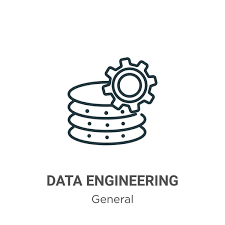
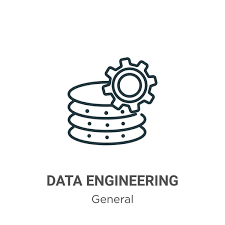


## **3.1 Family Size 👨‍👩‍👧**
The dataset provides information about the number of children (Kidhome) and teenagers (Teenhome) living in each customer’s household. These variables allow us to infer whether a customer is a parent and to estimate the size of their household. Both features are valuable for segmentation because family structure strongly influences purchasing behaviour, product preferences, and campaign responsiveness. This requires some feature engineering to create this new `Family_Size` variable. It will be created by combining the number of children, teenagers, and adults in the household "Parenting Status". 

This provides a concise view of each customer’s home‑life structure, which can influence purchasing behaviour and campaign responsiveness.This feature helps identify household structures such as single‑adult homes, small families, and larger family units, which often correlate with purchasing patterns and product preferences.

In [ ]:
# Check for customers that are parents - 'Parenting Status'
# Create a new feature 'Parenting_Status' indicating if the customer has children
dfa['Parenting_Status'] = np.where(dfa['Kidhome'] + dfa['Teenhome'] > 0, 'Has Children', 'No Children')

# Create a new feature 'Family_size' representing the total number of family members
dfa['Family_size'] = dfa['Kidhome'] + dfa['Teenhome'] + dfa['Marital_Status'].map({'Single': 1, 'Married': 2})  # +2 for parents

print(dfa['Parenting_Status'].value_counts())

# Analyze the 'Family_size' feature
dfa['Family_size'].describe()

## **3.2 Total Spent**

A `Total_Spent` feature was engineered by summing all product‑related spending fields.  
This gives a high‑level view of each customer’s lifetime value within the dataset and is a critical input for clustering and strategic targeting

To help with this, we need to address the inconsistencies in the product by renaming some of the labels given to the variables SKUs (Strategic Key Units) 

 #### 3.2.1 📦 Renaming Product (SKU) Columns for Clarity

The product spending variables are renamed to simpler, more intuitive labels (e.g., “Wines”, “Meat”, “Fish”). This enhances readability and ensures that the dataset is easier to interpret during exploratory analysis, feature engineering, and clustering.

In [ ]:
# Rename products names for Clarity
dfa = dfa.rename(columns={"MntWines": "Wines",
                            "MntFruits":"Fruits",
                            "MntMeatProducts":"Meat",
                            "MntFishProducts":"Fish",
                            "MntSweetProducts":"Sweets",
                            "MntGoldProds":"Gold"})

In [ ]:
# Create a new feature 'Total_Spent' representing the total amount spent by each customer
dfa['Total_Spent'] = dfa[['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']].sum(axis=1)

## **3.3 Total_Accepted_Campaigns**
A new feature, Total_Accepted_Campaigns, is engineered by summing all campaign acceptance indicators. This provides a consolidated measure of each customer’s promotional responsiveness and helps distinguish between highly engaged customers and those who are less receptive to marketing efforts. This feature is particularly valuable for clustering, as it captures behavioural differences that directly influence marketing strategy.

In [ ]:
# Create a new feature 'Total_Accepted_Campaigns' representing the total amount of campaigns accepted by each customer
dfa['Total_Accepted_Campaigns'] = dfa[['Response', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

## **3.4 Total_Purchases**
A new feature, Total_Purchases, is engineered by summing all purchase counts across catalogue, store, and web channels. This provides a consolidated measure of each customer’s transaction frequency and helps distinguish between high‑engagement and low‑engagement shoppers during clustering.

In [ ]:
# Create a new feature 'Total_Purchases' representing the total amount number of purchases by each customer
dfa['Total_Purchases'] = dfa[['NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases']].sum(axis=1)

# **4.0 📊EXPLORATORY DATA ANALYSIS (EDA) AND VISUALIZATION STRATEGY**

The dataset is rich in behavioural, demographic, and transactional information, offering multiple angles for exploration. Effective EDA helps uncover the underlying patterns that shape customer behaviour and ultimately strengthens the segmentation model. The visualizations proposed here are designed not only to understand the data but also to surface insights that are directly actionable for marketing, product strategy, and customer engagement.

This analysis will explore how demographic factors (such as age, education, and marital status), household structure, income levels, and purchasing behaviour interact to influence customer value and campaign responsiveness.

## **4.1 🔍Key Analytical Perspectives**

**1. Demographics and Customer Value**
Understanding how **age**, **marital status**, **education**, and **income** relate to **Total Spent** provides a foundation for identifying high‑value customer profiles. These insights help determine which demographic groups contribute most to revenue and which may require targeted engagement strategies.

**2. Product Preferences and Purchase Behaviour**
The dataset includes detailed SKU‑level spending (Wines, Fruits, Meat, Fish, Sweets, Gold). Visualizing the distribution and frequency of these purchases helps identify:

- Category specialists  
- High‑value product lines  
- Cross‑category purchasing patterns  

These insights are essential for designing SKU‑specific campaigns and promotions.

**3. Household Dynamics and Purchasing Patterns**
By examining the impact of **children in the household**, **family size**, and **age groups**, we can understand how life‑stage and household responsibilities influence spending behaviour. This perspective is particularly valuable for tailoring messaging and product recommendations.

**4. Income, Education, and SKU Choices**
Exploring the relationship between **Income**, **Education level**, and **Product preferences** helps identify which SKUs resonate with different socioeconomic groups. This supports strategic decisions around pricing, product positioning, and inventory planning.

**5. Campaign Responsiveness**
Understanding which customer groups respond to campaigns—and how campaign acceptance correlates with spending—helps optimize future marketing investments. Visualizing campaign performance across SKUs can reveal which product categories drive the highest promotional **ROI**.

## **4.2 📌Visualization Plan**

### **1. Bar Charts**
To visualize demographic distributions and their relationship with customer value:

- Age distribution with Total Spent trendline  
- Marital Status vs Total Spent  
- Education Level vs Total Spent  
- Income distribution with Total Spent overlay  

These charts help identify which demographic groups contribute most to revenue.

---

### **2. Histograms**
To explore SKU‑level sales distributions:

- Wines, Fruits, Meat, Fish, Sweets, Gold  

These visualizations highlight product popularity, spending concentration, and potential outliers.

---

### **3. Scatterplot / Pairplots**
To compare key behavioural and demographic variables:

- Income vs Total Spent  
- Age vs Total Spent  
- Income vs Age  
- All segmented by Marital Status  

These plots reveal spending patterns, value clusters, and demographic correlations.

---

### **4. Boxplots**
To examine the impact of household and educational factors:

- Family Size vs Total Spent  
- Education Level vs SKU Purchases  

Boxplots help identify variability, spending ranges, and group‑level differences.

---

### **5. Heatmaps**
To visualize correlations across key variables:

- Campaign acceptance (1–5 + Response) vs Total Spent  
- Customer demographics vs Total Spent  
- SKU spending correlations  

Heatmaps provide a high‑level view of which features are most influential and should be prioritized for clustering.

---
 ### **✨Summary**

> *This EDA framework provides a comprehensive view of customer behaviour across demographics, household structure, product preferences, and campaign responsiveness. The visualizations are designed to uncover actionable insights that support targeted marketing, SKU strategy, and customer segmentation. These findings will guide the selection of features for clustering and ensure that the resulting customer segments are both analytically sound and business‑relevant.*


In [ ]:
# Bar Charts: Age distribution with Total Spent trendline,
# Marital Status vs Total Spent, Education vs Total Spent, Income vs Total Spent
plt.figure(figsize=(10,6))

# Bar plot
sns.barplot(
    x='Education',
    y='Total_Spent',
    data=dfa,
    estimator=np.mean,
    color='skyblue'
)

# Trendline
edu_means = dfa.groupby('Education')['Total_Spent'].mean().values
plt.plot(edu_means, color='darkblue', marker='o', linewidth=2)

plt.title('Average Total Spent by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Average Total Spent')

plt.tight_layout()
plt.show()


In [ ]:
# Bar Charts: Age distribution with Total Spent trendline,
# Marital Status vs Total Spent, Education vs Total Spent, Income vs Total Spent
plt.figure(figsize=(10,6))

# Bar plot
sns.barplot(
    x='Education',
    y='Age',
    data=dfa,
    estimator=np.mean,
    color='skyblue'
)

# Trendline
age_means = dfa.groupby('Education')['Age'].mean().values
plt.plot(age_means, color='darkblue', marker='o', linewidth=2)

plt.title('Average Ages by Educational Level')
plt.xlabel('Education Level')
plt.ylabel('Customer\'s Average Age')

plt.tight_layout()
plt.show()


## **4.3 Bar Plot Of Customer Activity (Most Active Day of the Week)**

In [ ]:
# What day of the Week is most significant
plt.figure(figsize=(8,5))
dfa['Weekday'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Most Active Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

### **4.3.1 ✨Insights **
Customer activity peaks on Wednesday, followed by Monday and Friday. Tuesday shows the lowest activity. Sunday is naturally lower due to reduced business hours typical in many Western European regions. These patterns indicate that mid‑week is the optimal period for staffing, promotions, and customer engagement, while weekends require lighter operational support.

## **4.4 Spending Distribution per SKUs**

In [ ]:
# Histograms: Distribution of spending on different SKUs
# List of SKU columns
sku_cols = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

plt.figure(figsize=(12, 14))

for i, col in enumerate(sku_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(dfa[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


### **✨Insights ** 
The spending distributions across all SKUs (Wines, Fruits, Meat, Fish, Sweets, Gold) are right‑skewed, indicating that most customers spend small amounts while a smaller subset spends significantly more. This pattern highlights the presence of high‑value customers who disproportionately contribute to revenue, especially for premium (high valued) SKUs like Wines and Meat.

## **4.5 3D Scatter Plot: Income Vs Age Vs Spending**

In [ ]:
# 3D Scatter Plot: Income vs Age vs Total Spent
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

x = dfa['Income']
y = dfa['Age']
z = dfa['Total_Spent']

scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=40)

ax.set_xlabel('Income')
ax.set_ylabel('Age')
ax.set_zlabel('Total Spent')
ax.set_title('3D Scatter Plot: Income vs Age vs Total Spent')

fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()


### **4.5.1 ✨Insights **
This 3D scatter plot illustrates how **"Income"** and **"Age"** relate to **"Total_Spent"**. Most customers cluster at lower income and younger age ranges, showing modest spending. As income increases, spending rises noticeably, this is highlighted by the brighter colours on the plot. **"Age"** shows a weaker relationship with spending, with customers across different ages displaying similar spending patterns. A few high‑income, high‑spend outliers appear, representing niche premium customers.

In essence:  
**"Income"** is the strongest driver of spending, while **"Age"** plays a minimal role. The Business's customer base is concentrated among younger, lower‑income individuals, with a small but important group of high‑value earners contributing disproportionately to revenue.

## **4.6 📌Pair Plots of Parent VS Non-Parenting Customers**

In [ ]:
# Plot using pair plots for concise visualization
# -----------------------------------
# 1. Theme & Colour Setup
# -----------------------------------

sns.set_theme(
        rc={
        "axes.facecolor": "#FAF7F2",
        "figure.facecolor": "#FAF7F2",
        "axes.edgecolor": "#4A4A4A",
        "grid.color": "#669bbc"
    }
)

# To ensure we use the matplotlib.colors module (This is to avoid relying on a variable named `colors` that may be None)
from matplotlib import colors as mcolors

custom_cmap = mcolors.ListedColormap(["#9b2226", "#ae2012", "#ca6702", "#e9d8a6", "#bb3e03", "#005f73"])

# Refined, palette for Parenting_Status
pro_palette = ["#264653", "#92a9d8", "#e9c46a", "#Bf4a261", "#e76f51", "#F3AB60"]

# -----------------------------------
# 2. Select Features Using Project Labels
# -----------------------------------
# For the pairplot, we will pass only numeric variables via `vars=`.
numeric_vars = [
    "Income",
    "Recency",
    "Tenure",
    "Age",
    "Total_Spent",
    "Total_Purchases",
    "Total_Accepted_Campaigns"
]

# -----------------------------------
# 3. Pair Plot
# -----------------------------------
print("Pair Plot of Key Customer Features")

pair = sns.pairplot(
    data=dfa,
    vars=numeric_vars,
    hue="Parenting_Status",
    palette=pro_palette,
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 1.0, "s": 40, "edgecolor": "none"},
    diag_kws={"shade": True}
)

pair.fig.suptitle("Pair Plot of Customer Demographics & Behaviour", fontsize=20, y=1.02)

plt.tight_layout()
plt.show()


### **✨Insights **
The pair plot reveals that customers without children generally show higher variability in income and spending, and tend to cluster more strongly in higher‑spending regions. Parents, on the other hand, display more conservative spending patterns. Recency and Total Purchases show clear behavioural relationships, reinforcing that recent and frequent shoppers are higher‑value customers, regardless of parenting status.

## **4.7 The Boxplot Education Vs Spending per SKU**

In [ ]:
# Boxplot of Total_Spent Vs Family_Size
plt.figure(figsize=(10,6))
sns.boxplot(data=dfa, x='Family_size', y='Total_Spent', palette='viridis')
plt.title('Impact of Family Size on Total Spending')
plt.xlabel('Family Size')
plt.ylabel('Total Spent')
plt.tight_layout()
plt.show()

### **4.7.1 ✨Insights**
1. Customers with **smaller family sizes (1–2 members)** tend to spend more overall, showing **higher medians and wider variability in total spending**. In contrast, **larger families (3–5 members)** display **lower median spending and tighter ranges**, suggesting more conservative or budget-conscious behaviour. This pattern indicates that smaller households may have more discretionary income, while larger ones prioritize essentials. Outliers exist across all groups, highlighting niche high-value customers. Segmenting by family size will allow businesses to tailor product bundles and promotions—premium offerings for smaller households, and value-driven packages for larger ones.

In [ ]:
# Boxplot of Education level As a Measure of Spending 

sku_cols = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

plt.figure(figsize=(15, 18))

for i, col in enumerate(sku_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=dfa, x='Education', y=col, palette='viridis')
    plt.title(f'Impact of Education Level on {col} Purchases')
    plt.xlabel('Education Level')
    plt.ylabel(f'{col} Spend')

plt.tight_layout()
plt.show()

### **✨Insights **
Spending varies noticeably across education levels. Customers with **Master’s and Doctorate degrees consistently show higher spending in premium categories such as Wines, Meat, and Gold**. Meanwhile, customers with **High School or Undergraduate education tend to spend less and show tighter variability**. This suggests that education level is a meaningful indicator of purchasing power and product preference.

## **4.8📌Correlation HeatMap of Key Customer Features**

In [ ]:
# Correlation Heatmap of Key Customer Features
# -----------------------------------
# 1. Select Numerical Features
# -----------------------------------
corr_features = [
    'Income', 'Recency', 'Tenure', 'Age', 'Family_size',
    'Total_Spent', 'Total_Purchases', 'Total_Accepted_Campaigns',
    'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold'
]

corr_matrix = dfa[corr_features].corr()


# Custom colour palette (warm → cool)
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# -----------------------------------
# 3. Correlation Heatmap
# -----------------------------------
plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Key Customer Features", fontsize=20, pad=20)
plt.tight_layout()
plt.show()


### **4.8.1 ✨Insights**

Premium SKUs such as Wines, Meat, and Gold show strong positive correlations with Total_Spent, confirming their role as major revenue drivers. Campaign acceptance also correlates positively with spending, indicating that campaign‑responsive customers tend to be more valuable. Income shows only a weak correlation with spending, suggesting that behavioural features are more predictive than demographics.

### **4.9 Addressing the Outliers in the Age**

In [ ]:
# Trim the data using quantile ratio
dfa['Age'] = dfa['Age'].clip(lower=dfa['Age'].quantile(0.01),
                               upper=dfa['Age'].quantile(0.99))

### **4.10 Dropping Redundant Columns**

In [ ]:
dfa.info()

In [ ]:
to_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome', 'Day', 'Month', 'Year', 'Quarter']
dfa = dfa.drop(columns=to_drop)

# **5.0 📊FEATURE SELECTION: USING PRINCIPAL COMPONENT ANALYSIS (PCA)**

To prepare the dataset for effective clustering, the next step is to refine the feature space by reducing redundancy and improving data quality. Based on the exploratory analysis, several SKU spending variables are highly correlated, which can distort distance‑based clustering. Therefore, PCA will be applied selectively to the SKU spending block (Wines, Fruits, Meat, Fish, Sweets, Gold) to compress them into 1–2 meaningful components while preserving behavioural patterns. These PCA components will then be combined with key non‑SKU features such as Recency, Income, Total_Purchases, Total_Spent, and Campaign_Acceptance. Before PCA, all features will undergo outlier handling, skewness correction, and scaling to ensure stable and interpretable clusters.

In [ ]:
# Applying PCA for Dimensionality Reduction of the Product features

products = dfa[['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']]
scaler = StandardScaler()
products_scaled = scaler.fit_transform(products)
pca = PCA(n_components=2)
products_pca = pca.fit_transform(products_scaled)

print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)
plt.figure(figsize=(8,6))
plt.scatter(products_pca[:, 0], products_pca[:, 1], alpha=0.7, c='skyblue')
plt.title('PCA of Product Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.tight_layout()
plt.show()  

In [ ]:
# Visualizing PCA Loadings for SKU Features
# Assuming your PCA object is named 'pca'
# And your SKU features are stored in a list:
sku_features = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

# Extract loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=sku_features
)

# Plot loadings for PC1 and PC2
plt.figure(figsize=(10, 6))
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap='viridis', center=0)
plt.title('PCA Loadings for SKU Features (PC1 & PC2)')
plt.ylabel('SKU Features')
plt.xlabel('Principal Components')
plt.show()

## **5.1 ✨Insights from the PCA**

The PCA loadings reveal how each SKU feature contributes to the first two principal components:

**PC1** is driven by Meat (0.44), Fish (0.44), Fruits (0.43), Sweets (0.42), Wines (0.37) — indicating a general spending intensity across all SKUs, especially premium and staple items.

**PC2** is shaped by Wines (0.60) and Gold (0.55) positively, and Sweets (-0.39), Fruits (-0.33), Fish (-0.27) negatively — suggesting a contrast between luxury vs everyday spending.

Together, **PC1 and PC2** capture both overall spending behaviour and product preference orientation, enabling more interpretable clustering.


 # 6.0 **CLUSTERING: PREPROCESSING AND PROCESSING**

Following exploratory analysis and correlation review, PCA will be selectively applied to SKU spending features to reduce redundancy and dimensionality. The resulting principal components will be combined with key behavioural and demographic features — **Recency, Income, Total_Purchases, Total_Spent, and Campaign_Acceptance**— to form the final clustering dataset. All features will be preprocessed through outlier handling, skewness correction, and scaling to ensure stability and comparability. This refined feature set will be used to perform clustering using **KMeans Clustering**, enabling discovery of meaningful customer segments for targeted marketing and strategic profiling.

In [ ]:
# Manual Feature Selection of the numeric features for Clustering
# This ensure the PCA components are present in the customer dataframe
if 'PCA_Component_1' not in dfa.columns or 'PCA_Component_2' not in dfa.columns:
    dfa['PCA_Component_1'] = products_pca[:, 0]
    dfa['PCA_Component_2'] = products_pca[:, 1]

selected_features = [
    'Income', 'Recency', 'Tenure', 'Age', 'Family_size',
    'Total_Spent', 'Total_Purchases', 'Total_Accepted_Campaigns',
    'PCA_Component_1', 'PCA_Component_2'
]

# Create dataframe for clustering using the selected features
cluster_df = dfa[selected_features].copy()
cluster_df.head()



# from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_df)

In [ ]:
# Elbow Method to determine optimal number of clusters

Spending = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    Spending.append(kmeans.inertia_)



plt.figure(figsize=(8, 5))
plt.plot(K, Spending, marker='o')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Spending of Customers')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import calinski_harabasz_score

In [ ]:
# Fit KMeans with optimal number of clusters
kmeans_final = KMeans(n_clusters=5, random_state=42)
dfa['Cluster'] = kmeans_final.fit_predict(cluster_scaled)

# Calculate CH score
ch_score = calinski_harabasz_score(cluster_scaled, dfa['Cluster'])
print(f"Calinski–Harabasz Score: {ch_score:.2f}")

## **6.1 Clustering Outcome**

Based on the Calinski–Harabasz score of 465.57 and the elbow plot, the optimal number of clusters appears to be around 4 or 5, as this is where the inertia begins to level off and the rate of improvement slows.

In [ ]:
# Visualize Clusters using PCA components

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=dfa['PCA_Component_1'],
    y=dfa['PCA_Component_2'],
    hue=dfa['Cluster'],
    palette='Set2'
)
plt.title('Customer Segments by PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Print the cluster profile
cluster_profile = dfa.groupby('Cluster')[selected_features].mean().round(2)
cluster_profile

# **7.0 📄CONCLUSION: Cluster Outcome Analysis**

### **Cluster 0 — At-Risk Minimalists**
- **Profile:**  These are low income, low spending customers with low engagement  
- **Key Metrics:**  
  - Income: £30,484  
  - Total Spent: £108  
  - Purchases: 6
  - Family Size: 2 or more
  - Campaigns Accepted: 0.21  
  - PCA: Strong negative on PC1 and PC2
    
- **Strategic Insight:**  
This segment shows minimal engagement and low value contribution. The customers are younger, have moderate tenure, and rarely respond to campaigns. They may be disengaged or price-sensitive.
  
- **Recommended Action:**  
Appropriate action for this customer will be light-touch win-back campaigns or passive retention strategies. Businesses should avoid high investment in acquiring these types of customers.

---

### **Cluster 1 — Steady Traditionalists**
- **Profile:** Moderate income, moderate spending, consistent engagement  
- **Key Metrics:**  
  - Income: £61,372  
  - Total Spent: £921  
  - Purchases: 18.8
  - Family Size: 2 or more 
  - Campaigns Accepted: 0.39  
  - PCA: Slight positive on PC1 and strong positive on PC2

- **Strategic Insight:**  
 These are older, stable customers with moderate family size and reliable purchasing behaviour. They respond modestly to campaigns and prefer routine. Prime customers for **Gold and Wines**, the optimum drivers for PC2 SKUs.
  
- **Recommended Action:**  
Actions can be taken to reinforce loyalty of this customer cluster through convenience, subscriptions, and bundled essentials.

---

### **Cluster 2 — Premium Loyalists**
- **Profile:** High income, highest spending, strong engagement  
- **Key Metrics:**  
  - Income: £79,787  
  - Total Spent: £1,616  
  - Purchases: 19.9
  - Family Size: 1 or 2
  - Campaigns Accepted: 2.91  
  - PCA: Strong positive on both components

- **Strategic Insight:**  
This is the most valuable segment. Customers are affluent, highly engaged, and responsive to campaigns. They prefer premium products and exhibit broad purchasing behaviour.
  
- **Recommended Action:**  
This cluster of customers should be prioritized and targeted with personalized offers, VIP programs, and premium product curation.

---

### **Cluster 3 — Value Seekers**
- **Profile:** Lower-middle income, low spending, low engagement  
- **Key Metrics:**  
  - Income: £44,709
  - Total Spent: £171
  - Family Size: 3 or more
  - Purchases: 7.7  
  - Campaigns Accepted: 0.14  
  - PCA: Strong negative on PC1

- **Strategic Insight:**  
These are older customers with large families and long tenure, however they have low spending capacity and have responded to minimal campaigns. They largely focused on essentials.

- **Recommended Action:**
These customers can be offered value bundles and can be targeted with affordability-focused messaging.  Business should maintain customer engagement using low cost channels.

---

### **Cluster 4 — Affluent Selective Spenders**
- **Profile:** High income, strong spending, selective engagement  
- **Key Metrics:**  
  - Income: £74,155  
  - Total Spent: £1,223  
  - Purchases: 19.3
  - Family Size: 1 or 2
  - Campaigns Accepted: 0.35  
  - PCA: Strong positive on PC1, negative on PC2

- **Strategic Insight:**  
These customers spend heavily but engage selectively. They prefer premium products and are less responsive to promotions.
    
- **Recommended Action:**  
Businesses can target these customers by using subtle, curated messaging and premium positioning, however, there is a need to approach these customers with caution to avoid over-targeting with them with campaigns.

## **7.1 Summary of Strategic Implications**

- **Clusters 2 and 4** are high-value and should be prioritized for growth and retention.  
- **Cluster 1** offers stable revenue and benefits from convenience-driven strategies.  
- **Clusters 0 and 3** require selective investment and cost-efficient engagement.  
- PCA components confirm strong behavioural separation, validating the segmentation structure.
- EDA reveals midweek is the optimal period for staffing, promotions, and customer engagement, while weekends require lighter operational support


# **THE END**